# Serving ML/DL models

This notebook demonstrate how to serve standard ML/DL models using **MLRun Serving**.

Make sure you went over the basics in MLRun [**Quick Start Tutorial**](./01-mlrun-basics.html).


MLRun serving can produce managed real-time serverless pipelines from various tasks, including MLRun models or standard model files.
The pipelines use the Nuclio real-time serverless engine, which can be deployed anywhere.
[Nuclio](https://nuclio.io/) is a high-performance open-source "serverless" framework that's focused on data, I/O, and compute-intensive workloads.


MLRun serving supports advanced real-time data processing and model serving pipelines.<br>
For more details and examples, see the {ref}`MLRun serving pipelines <serving>` documentation.

Tutorial steps:
- [**Using pre-built MLRun serving classes and images**](#pre-built-serving)
- [**Create and test the Serving Function**](#create-function)
- [**Deploy the serving Function**](#deploy-serving)
- [**Build a custom serving class**](#custom-class)
- [**Building advanced model Serving Graph**](#serving=graph)

## MLRun installation and configuration

Before running this notebook make sure the `mlrun` package is installed (`pip install mlrun`) and that you have configured the access to MLRun service. 

In [1]:
# install MLRun if not installed, run this only once (restart the notebook after the install !!!)
# %pip install mlrun

**Get or create a new project:**

You should create, load or use (get) an {ref}`MLRun Project<Projects>`. The `get_or_create_project()` method tries to load the project from the MLRun DB. If the project does not exist it creates a new one.

In [2]:
import mlrun
project = mlrun.get_or_create_project("tutorial", context="src/", user_project=True)

> 2022-08-24 08:53:27,460 [info] loaded project tutorial from MLRun DB


<a id="pre-built-serving"></a>
## Using pre-built MLRun serving classes and images

MLRun contains built-in serving functionality for the major ML/DL frameworks (Scikit-Learn, TensorFlow.Keras, ONNX, XGBoost, LightGBM and PyTorch). In addition MLRun provide a few container images with the required ML/DL packages pre-installed.

You can overwrite the packages in the images, or provide your own image (just need to make sure that the `mlrun` package is installed in it).  

The following table specifies, for each framework, the relevant pre-integrated image and the corresponding MLRun `ModelServer` serving class:

|framework       |image          |serving class                               |
|:---------------|:--------------|:-------------------------------------------|
|SciKit-Learn    |mlrun/mlrun    |mlrun.frameworks.sklearn.SklearnModelServer |
|TensorFlow.Keras|mlrun/ml-models|mlrun.frameworks.tf_keras.TFKerasModelServer|
|ONNX            |mlrun/ml-models|mlrun.frameworks.onnx.ONNXModelServer       |
|XGBoost         |mlrun/ml-models|mlrun.frameworks.xgboost.XGBoostModelServer | 
|LightGBM        |mlrun/ml-models|mlrun.frameworks.lgbm.LGBMModelServer       |
|PyTorch         |mlrun/ml-models|mlrun.frameworks.pytorch.PyTorchModelServer |

> For GPU support use the `mlrun/ml-models-gpu` image (adding GPU drivers and support)

**Example using SKlearn and TF Keras models**

See how to specify the parameters in the following two examples. These use standard pre-trained models (using the iris dataset) stored in MLRun samples repository. (You can use your own models instead.)

In [3]:
models_dir = mlrun.get_sample_path('models/serving/')

framework = 'sklearn'  # change to 'keras' to try the 2nd option 
kwargs = {}
if framework == "sklearn":
    serving_class = 'mlrun.frameworks.sklearn.SklearnModelServer'
    model_path = models_dir + 'sklearn.pkl'
    image = 'mlrun/mlrun'
else:
    serving_class = 'mlrun.frameworks.tf_keras.TFKerasModelServer'
    model_path = models_dir + 'keras.h5'
    image = 'mlrun/ml-models'  # or mlrun/ml-models-gpu when using GPUs
    kwargs['labels'] = {'model-format': 'h5'}

### Logging the model

The model and its metadata are first registered in MLRun's **Model Registry**. Use the `log_model()` method to specify the model files and metadata (metrics, schema, parameters, etc.).

In [4]:
model_object = project.log_model(f'{framework}-model', model_file=model_path, **kwargs)

<a id="create-function"></a>
## Create and test the serving function 

Create a new **`serving`** function, specify its `name` and the correct `image` (with your desired framework).

> If you want to add specific packages to the base image, specify the `requirements` attribute, example:
> 
> ```python
> serving_fn = mlrun.new_function("serving", image=image, kind="serving", requirements=["tensorflow==2.8.1"])
> ```

The following example uses a basic topology of a model `router` and adds a single model behind it (you can add multiple models to the same function)

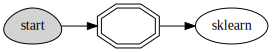

In [5]:
serving_fn = mlrun.new_function("serving", image=image, kind="serving", requirements={})
serving_fn.add_model(framework ,model_path=model_object.uri, class_name=serving_class, to_list=True)

# Plot the serving topology input -> router -> model
serving_fn.plot(rankdir="LR")

**Simulating the model server locally (using the mock_server):**

In [6]:
# create a mock server that represents the serving pipeline
server = serving_fn.to_mock_server()

> 2022-08-24 08:53:27,726 [warning] run command, file or code were not specified
> 2022-08-24 08:53:32,250 [info] model sklearn was loaded
> 2022-08-24 08:53:32,252 [info] Loaded ['sklearn']


Trying to unpickle estimator DecisionTreeClassifier from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
Trying to unpickle estimator RandomForestClassifier from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations


<br>

**Test the mock model server endpoint:**
    
- List the served models

In [7]:
server.test("/v2/models/", method="GET")

{'models': ['sklearn']}

- Infer using test data

In [8]:
sample = {"inputs":[[5.1, 3.5, 1.4, 0.2],[7.7, 3.8, 6.7, 2.2]]}
server.test(path=f'/v2/models/{framework}/infer',body=sample)

{'id': '28bab37fdc0a4ec19e446191894f9f6c',
 'model_name': 'sklearn',
 'outputs': [0, 2]}

<br>

> See more API options and parameters in the **{ref}`Model serving API documentation <model-api>`**.

<a id="deploy-serving"></a>
## Deploy the serving function

Deploy the serving function and use `invoke` to test it with the provided `sample`.

In [9]:
serving_fn.with_code(body=" ") # adds the serving wrapper, not required with MLRun >= 1.0.3
project.deploy_function(serving_fn)

> 2022-08-24 08:53:32,334 [warning] it is recommended to use k8s secret (specify secret_name), specifying the aws_access_key/aws_secret_key directly is unsafe
> 2022-08-24 08:53:32,343 [info] Starting remote function deploy
2022-08-24 08:53:32  (info) Deploying function
2022-08-24 08:53:32  (info) Building
2022-08-24 08:53:32  (info) Staging files and preparing base images
2022-08-24 08:53:32  (info) Building processor image
2022-08-24 08:57:27  (info) Build complete
2022-08-24 08:57:48  (info) Function deploy complete
> 2022-08-24 08:57:49,042 [info] successfully deployed function: {'internal_invocation_urls': ['nuclio-tutorial-jovyan-serving.mlrun.svc.cluster.local:8080'], 'external_invocation_urls': ['localhost:32129']}


DeployStatus(state=ready, outputs={'endpoint': 'http://localhost:32129', 'name': 'tutorial-jovyan-serving'})

In [10]:
serving_fn.invoke(path=f'/v2/models/{framework}/infer',body=sample)

> 2022-08-24 08:57:49,138 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-tutorial-jovyan-serving.mlrun.svc.cluster.local:8080/v2/models/sklearn/infer'}


{'id': '40325ba7-3f1f-461c-9aa1-4fc66b2e196e',
 'model_name': 'sklearn',
 'outputs': [0, 2]}

<a id="custom-class"></a>
## Building a custom serving class

Model serving classes implement the full model serving functionality, which include loading models, pre- and post-processing, prediction, explainability, and model monitoring.

Model serving classes must inherit from `mlrun.serving.V2ModelServer`, and at the minimum implement the `load()` (download the model file(s) and load the model into memory) and `predict()` (accept request payload and return prediction/inference results) methods.

For more detailed information on custom serving classes, see {ref}`Creating a custom model serving class <custom-model-serving-class>`.

The following code demonstrates a minimal scikit-learn (a.k.a. sklearn) serving-class implementation:


```python
from cloudpickle import load
import numpy as np
from typing import List
import mlrun

class ClassifierModel(mlrun.serving.V2ModelServer):
    def load(self):
        """load and initialize the model and/or other elements"""
        model_file, extra_data = self.get_model('.pkl')
        self.model = load(open(model_file, 'rb'))

    def predict(self, body: dict) -> List:
        """Generate model predictions from sample."""
        feats = np.asarray(body['inputs'])
        result: np.ndarray = self.model.predict(feats)
        return result.tolist()
```

In order to create a function that incorporates the code of the new class (in `serving.py` ) use `code_to_function`:

```python
serving_fn = mlrun.code_to_function('serving', filename='serving.py', kind='serving',image='mlrun/mlrun')
serving_fn.add_model('my_model',model_path=model_file, class_name='ClassifierModel')
```

<a id="serving=graph"></a>
## Building an advanced model serving graph

MLRun graphs enable building and running DAGs (directed acyclic graph). Graphs are composed of individual steps. 
The first graph element accepts an `Event` object, transforms/processes the event and passes the result to the next step
in the graph, and so on. The final result can be written out to a destination (file, DB, stream, etc.) or returned back to the caller 
(one of the graph steps can be marked with `.respond()`). 

The serving graphs can be composed of pre-defined graph steps, block-type elements (model servers, routers, ensembles, 
data readers and writers, data engineering tasks, validators, etc.), custom steps, or from native python 
classes/functions. A graph can have data processing steps, model ensembles, model servers, post-processing, etc. 
Graphs can auto-scale and span multiple function containers (connected through streaming protocols).

See the **{ref}`Advanced Model Serving Graph Notebook Example <graph-example>`**. 

## Done!

Congratulations! You've completed Part 3 of the MLRun getting-started tutorial.
Proceed to [**Part 4: ML Pipeline**](04-pipeline.ipynb) to learn how to create an automated pipeline for your project.